In [67]:
from Datafunctions import*
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Notwendige Dateien:
#PLZ-Deutschland.xlsx
#plz-gebiete.shp

# 1. Datenvorbereitung

In [2]:
df = openfile()
df = cleanfile(df)

<ipython-input-2-e14e97863b88>:1: DtypeWarning: Columns (31,32,33,34,38,40,42,43,44,45,46,47,48,49,54,56,57,58,59,60,63) have mixed types.Specify dtype option on import or set low_memory=False.
  df = openfile()


# 1.1 Ausreißerbereinigung


<AxesSubplot:>

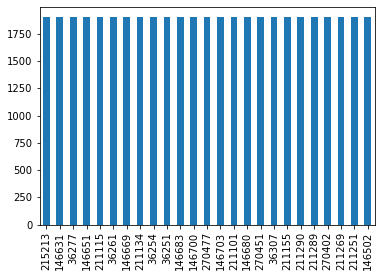

In [12]:
#Baujahr bereinigen, abstellen auf zweites Feature
df.loc[(df["Baujahr"]>2022)&(df["Baujahr laut Energieausweis"]<2022),"Baujahr"] = df.loc[(df["Baujahr"]>2022)&(df["Baujahr laut Energieausweis"]<2022),"Baujahr laut Energieausweis"]
df.loc[(df["Baujahr"]>2024),"Baujahr"]=np.nan
df.loc[(df["Baujahr"]<1900),"Baujahr"]=1900
df["Baujahr"].sort_values(ascending=True)[:25].plot(kind="bar")


In [10]:
#Endenergiebedarf formatieren
df.loc[~df["Endenergiebedarf"].isna(),"Endenergiebedarf"] = df.loc[~df["Endenergiebedarf"].isna(),"Endenergiebedarf"].apply(lambda x:x.replace(" kWh/(m²·a)","").replace(",","."))
df["Endenergiebedarf"] = np.floor(pd.to_numeric(df['Endenergiebedarf'], errors='coerce')).astype('Float64')

In [20]:
#Einträge ohne Kaltmiete entfernen
df.dropna(subset=["Kaltmiete"],inplace=True)

#Einträge mit Kaltmiete kleiner 100 EUR entfernen
df.drop(labels=df[df["Kaltmiete"]<100].index,inplace=True)
#Einträge mit Kaltmiete größer 6000 EUR entfernen
df.drop(labels=df[df["Kaltmiete"]>6000].index,inplace=True)

#Einträge mit Größe kleiner 10qm entfernen
df.drop(labels=df[df["Größe"]<10].index,inplace=True)
#Einträge mit Größe größer 2000qm entfernen
df.drop(labels=df[df["Größe"]>2000].index,inplace=True)



In [31]:
#KPIs berechnen

df["Preis/m² (Kalt)"] = round(df["Kaltmiete"]/df["Größe"],2)
df["Preis/m² (Nebenkosten)"] = round(df["Nebenkosten"]/df["Größe"],2)
df["Preis/m² (Warm)"] = round(df["Warmmiete"]/df["Größe"],2)

[Text(0.5, 0, 'ID'), Text(0, 0.5, 'Preis/m² (Warm)')]

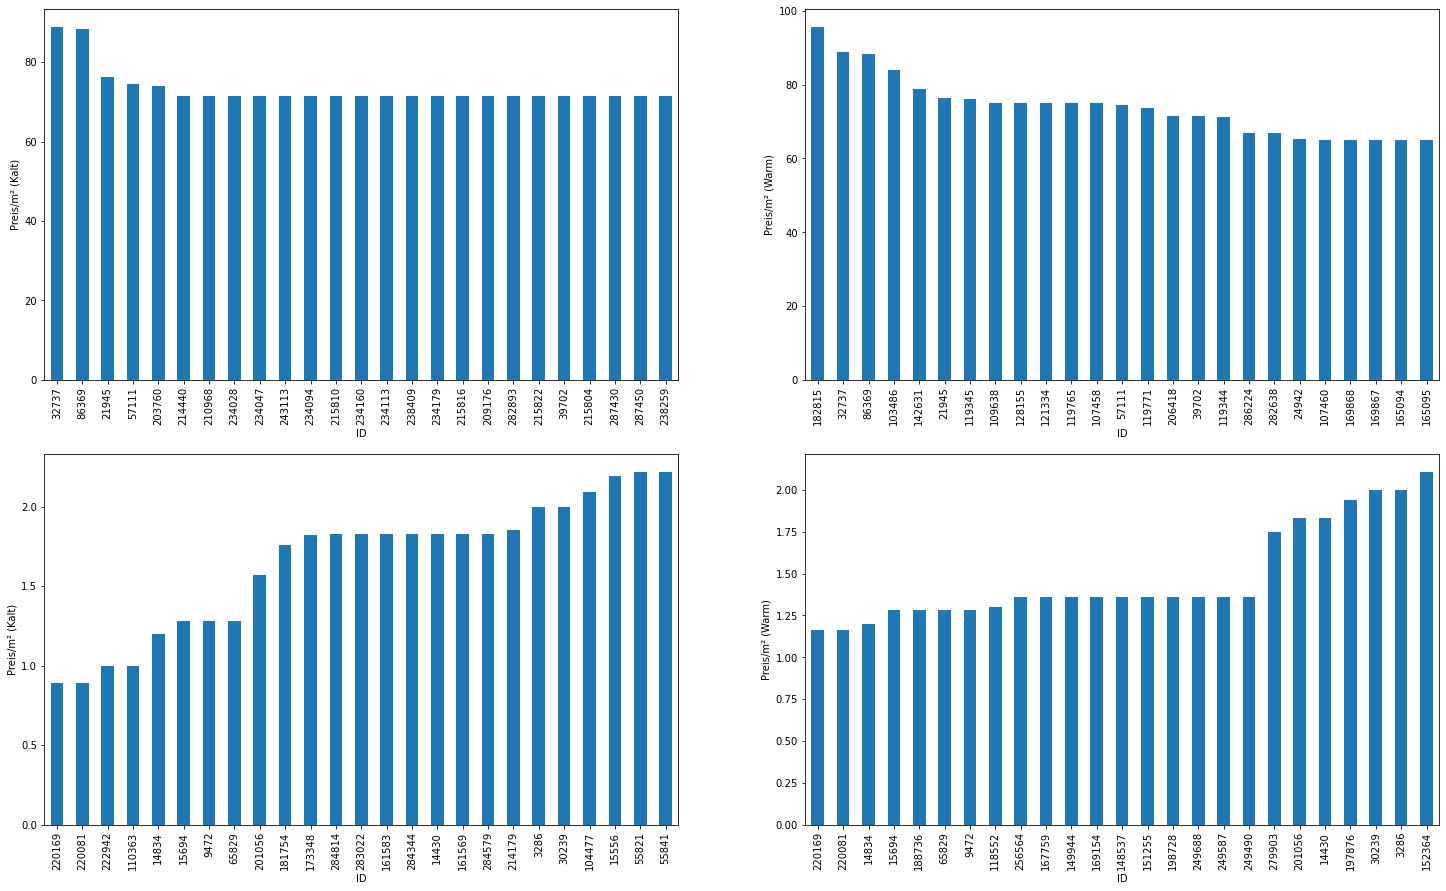

In [37]:
#Ausreißersuche

fig, axs = plt.subplots(2,2)
fig.set_figwidth(25)
fig.set_figheight(15)


df["Preis/m² (Kalt)"].max()
df.iloc[df["Preis/m² (Kalt)"].argmax()]
df["Preis/m² (Kalt)"].sort_values(ascending=False)[:25].plot(kind="bar", ax=axs[0, 0])
axs[0,0].set(xlabel="ID", ylabel="Preis/m² (Kalt)")

df["Preis/m² (Warm)"].max()
df.iloc[df["Preis/m² (Warm)"].argmax()]
df["Preis/m² (Warm)"].sort_values(ascending=False)[:25].plot(kind="bar", ax=axs[0, 1])
axs[0,1].set(xlabel="ID", ylabel="Preis/m² (Warm)")


df["Preis/m² (Kalt)"].min()
df.iloc[df["Preis/m² (Kalt)"].argmin()]
df["Preis/m² (Kalt)"].sort_values(ascending=True)[:25].plot(kind="bar", ax=axs[1, 0])
axs[1,0].set(xlabel="ID", ylabel="Preis/m² (Kalt)")

df["Preis/m² (Warm)"].min()
df.iloc[df["Preis/m² (Warm)"].argmin()]
df["Preis/m² (Warm)"].sort_values(ascending=True)[:25].plot(kind="bar", ax=axs[1, 1])
axs[1,1].set(xlabel="ID", ylabel="Preis/m² (Warm)")

In [36]:
#Einträge mit Warmmiete pro m² größer 100 EUR entfernen
df.drop(labels=df[df["Preis/m² (Warm)"]>100].index,inplace=True)

#Einträge mit Warmmiete pro m² kleiner 1 EUR entfernen
df.drop(labels=df[df["Preis/m² (Warm)"]<1].index,inplace=True)


# 2. Explorative Datenanalyse

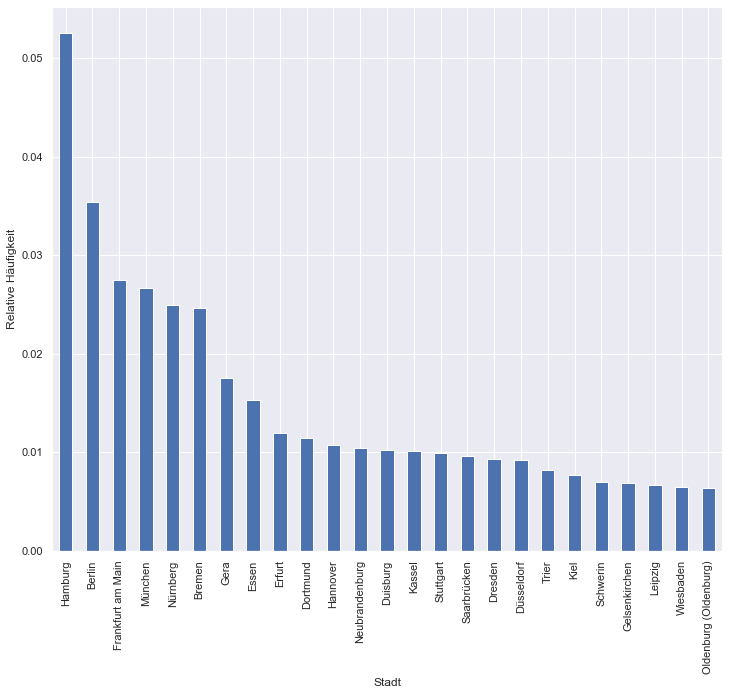

In [61]:
#Explorativ
df["Stadt"].value_counts(normalize=True).head(25).plot(kind="bar")
plt.ylabel("Relative Häufigkeit")
plt.xlabel("Stadt")
plt.show()

# 2.1 Aggregation nach Städte-Cluster

In [43]:
#Gruppierung der Daten anhand Städte-Cluster (Erstellung eines "grouped_df")

df["Preis/m² (Kalt)"] = round(df["Kaltmiete"]/df["Größe"],2)
df["Preis/m² (Nebenkosten)"] = round(df["Nebenkosten"]/df["Größe"],2)
df["Preis/m² (Warm)"] = round(df["Warmmiete"]/df["Größe"],2)
df["BRW-Anteil"] = (df["BRW"])/(df["Preis/m² (Kalt)"]*12)

grouped_df=df.groupby(by=df["Stadt"]).agg("mean")
grouped_df["Anzahl"]=df.groupby(by=df["Stadt"]).agg("count")["Datum"]
grouped_df = grouped_df.round(2) 

#Anzeigen der Top15-Städte (meiste Einträge)
grouped_df.sort_values(by='Anzahl', ascending=False)[:15]




,Größe,Zimmer,Kaltmiete,Nebenkosten,Warmmiete,PLZ,Baujahr,Preis/m² (Kalt),Preis/m² (Nebenkosten),Preis/m² (Warm),Baujahr laut Energieausweis,Endenergiebedarf,Boris_NRW_ID,BORIS_NRW,BRW,BRW-Anteil,BORIS_ID,Unnamed: 62,Anzahl
Stadt,,,,,,,,,,,,,,,,,,,
Hamburg,66.80,2.36,963.76,174.24,1109.95,21757.71,1974.19,14.52,2.70,16.76,1980.5,91.24,NaN,NaN,2659.81,14.67,14839.41,NaN,14356
Berlin,66.49,2.23,1125.85,197.40,1278.17,12013.85,1985.87,18.74,3.23,21.59,1975.12,86.99,19767.0,NaN,NaN,NaN,NaN,NaN,9681
Frankfurt am Main,62.53,2.43,1043.00,206.96,1184.25,60691.28,1981.73,18.61,3.95,21.63,1983.24,94.34,NaN,NaN,NaN,NaN,NaN,NaN,7523
München,66.89,2.23,1479.56,250.64,1659.79,81177.62,1990.96,23.27,4.10,26.51,1997.82,73.09,NaN,NaN,NaN,NaN,NaN,NaN,7274
Nürnberg,64.09,2.27,736.62,150.96,858.60,90444.45,1971.05,12.10,2.52,14.19,1976.05,104.13,NaN,NaN,NaN,NaN,NaN,NaN,6826
Bremen,67.22,2.51,652.85,159.40,736.12,28322.51,1974.57,9.67,2.43,11.23,1972.08,110.61,NaN,NaN,NaN,NaN,NaN,NaN,6733
Gera,59.85,2.35,350.29,109.14,438.23,7547.22,1952.56,5.78,1.83,6.83,1943.19,91.11,NaN,NaN,NaN,NaN,NaN,NaN,4795
Essen,61.47,2.53,507.50,141.36,613.30,45229.20,1958.28,8.32,2.33,10.08,1957.26,120.78,NaN,10010.90,233.90,2.44,9562.45,NaN,4170
Erfurt,64.65,2.43,545.09,158.25,668.67,99089.36,1957.66,8.31,2.49,10.28,1963.44,92.34,NaN,NaN,NaN,NaN,NaN,NaN,3263


In [45]:
#Veranschaulichung der Verteilungsparameter ("Mean","Median","Std-Abweichung","Max-Wert") - Hinweis: Bodenrichtwerte (BRW) nicht für alle Städte/Einträge vorhanden

cities =["Aachen","Bochum","Dortmund","Düsseldorf","Köln","Essen","Bielefeld","Münster","München","Hamburg"]
measures=["mean","50%","std","max"]
items=["Größe","Preis/m² (Kalt)","BRW", "BRW-Anteil","Baujahr","Preis/m² (Nebenkosten)"]
fulldf = pd.DataFrame()
df3 = pd.DataFrame()
df2=pd.DataFrame()
for y in cities:
    df3 = pd.DataFrame()
    for x in measures:
        df2 = df.loc[df["Stadt"]==y].describe().loc[[x],items]
        df2 = df2.add_suffix(f"_{x}")
        df2.set_index([[y]],inplace=True)
        if df3.empty:
            df3 = df2
        else:
            df3 = pd.merge(df2, df3, left_index=True, right_index=True)
    
    fulldf = fulldf.append(df3,ignore_index=False)

fulldf = fulldf.reindex(sorted(fulldf.columns), axis=1)
fulldf


,BRW-Anteil_50%,BRW-Anteil_max,BRW-Anteil_mean,BRW-Anteil_std,BRW_50%,BRW_max,BRW_mean,BRW_std,Baujahr_50%,Baujahr_max,Baujahr_mean,Baujahr_std,Größe_50%,Größe_max,Größe_mean,Größe_std,Preis/m² (Kalt)_50%,Preis/m² (Kalt)_max,Preis/m² (Kalt)_mean,Preis/m² (Kalt)_std,Preis/m² (Nebenkosten)_50%,Preis/m² (Nebenkosten)_max,Preis/m² (Nebenkosten)_mean,Preis/m² (Nebenkosten)_std
Aachen,1.500000,16.984678,2.248858,2.433475,185.00,2350.00,280.501416,292.095142,1969.0,2022.0,1970.253378,30.930357,62.00,220.00,65.703463,30.680158,10.00,36.00,11.023740,3.657448,2.38,9.56,2.684446,1.185233
Bochum,3.820128,26.190476,4.039685,1.980299,360.00,2200.00,380.076031,172.804633,1959.0,2022.0,1960.429624,25.581260,59.21,170.00,61.514861,19.996492,7.90,19.14,8.144737,2.009373,2.26,10.00,2.357071,0.983103
Dortmund,3.370525,72.523262,3.713933,4.577546,320.00,5300.00,357.078156,370.643759,1964.0,2022.0,1965.353654,25.870130,60.32,200.00,62.553063,21.339498,8.33,22.22,8.566302,2.080567,2.22,19.34,2.325732,0.867478
Düsseldorf,1.914304,58.905059,4.888759,7.058663,260.00,7300.00,788.412689,1208.191119,1968.0,2022.0,1970.476234,31.667565,63.84,333.00,68.684386,30.724441,12.06,36.29,13.324140,4.151886,2.57,23.21,2.791557,1.184353
Köln,2.740055,30.416667,4.695282,4.182895,440.00,4380.00,741.181544,671.348228,1973.0,2023.0,1977.726845,29.902393,65.00,224.97,67.503613,29.850604,12.63,39.88,13.982523,4.873128,2.66,17.05,2.872723,1.283380
Essen,2.224627,16.193323,2.435214,1.642773,220.00,1300.00,233.896149,159.760617,1958.0,2022.0,1958.284199,25.670956,59.09,198.13,61.474108,18.966841,8.10,30.50,8.323398,2.177225,2.22,11.11,2.333607,0.800676
Bielefeld,3.302510,47.619048,4.344579,4.977846,300.00,5800.00,419.574074,606.882497,1970.0,2023.0,1978.246154,28.016549,63.24,190.00,64.710595,21.459626,8.30,21.67,8.482006,2.083101,2.29,7.50,2.431996,0.803978
Münster,3.294992,19.333333,4.346039,4.917159,380.00,2900.00,640.780808,791.510798,1984.0,2022.0,1985.976378,30.652242,71.13,250.00,74.223565,35.804549,12.00,29.29,12.474848,3.275511,2.50,7.50,2.721196,1.090037
München,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996.0,2022.0,1990.958239,31.640262,62.00,348.00,66.888423,32.083332,22.26,66.00,23.274588,7.023116,3.42,26.00,4.098780,2.181563
Hamburg,10.317832,148.988737,14.672795,12.572745,1645.77,24463.57,2659.807332,2874.146438,1971.0,2023.0,1974.190861,37.588847,62.55,310.00,66.802079,27.822849,13.64,45.83,14.518100,5.009898,2.43,26.11,2.702654,1.464416


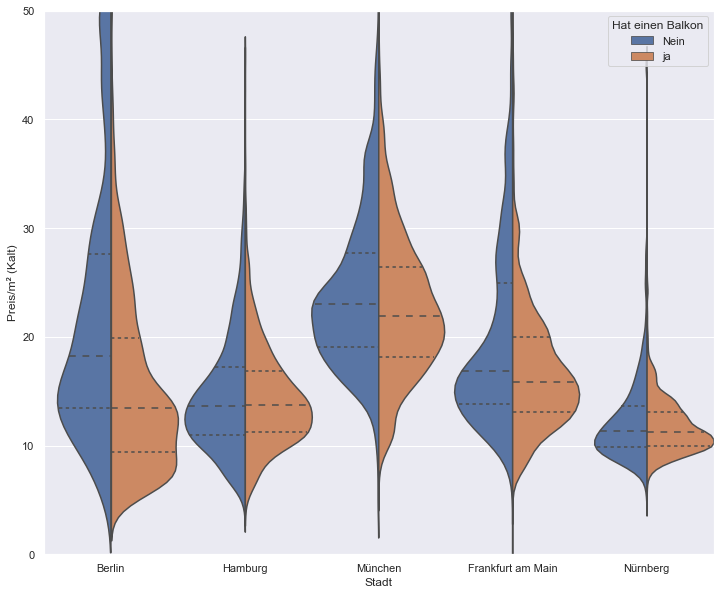

In [62]:
#Visualisierung der Verteilung von Kaltmietniveaus für ausgewählte Städte, wahlweise differenziert nach Ausstattungsmerkmalen (hier: hat einen Balkon / hat keinen Balkon)

x_filt="Stadt"
y_filt="Preis/m² (Kalt)"
h_filt="Sonstiges"
h_value="Balkon"

sns.set(rc={"figure.figsize":(12,10)})

ax = sns.violinplot(y="Preis/m² (Kalt)",x="Stadt",data=df.loc[df[x_filt].isin(df[x_filt].value_counts()[:5].index)],points=2, width=1,split=True,
                    inner="quartile", bw=.2,hue=np.select(condlist=[["Balkon" in str(x) for x in df.loc[df[x_filt].isin(df[x_filt].value_counts()[:5].index),h_filt]]],choicelist=[["ja"]], default="Nein"))

ax.set_ylim(ymin=0,ymax=50)

ax.legend(title= 'Hat einen Balkon')

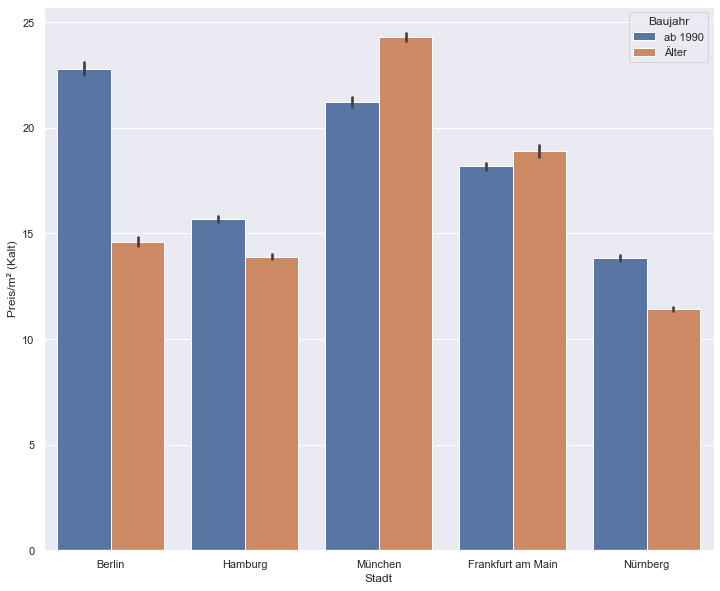

In [64]:
#Durchschnittliches Kaltmietniveau in Abhängigkeit des Baujahres

ax = sns.barplot(x="Stadt",y="Preis/m² (Kalt)", data = df.loc[df[x_filt].isin(df[x_filt].value_counts()[:5].index)], hue=df.loc[df[x_filt].isin(df[x_filt].value_counts()[:5].index),"Baujahr"].fillna(0).apply(lambda x: "ab 1990" if x > 1990 else "Älter"))

In [49]:
#Teil 1: Korrelationstabelle für ausgewählte Parameter (weiterhin Aggregation von Städten)

cities =["Aachen","Hamburg","Dortmund","Düsseldorf","Köln","Essen","Bielefeld","Münster"]

items=["Größe","Preis/m² (Kalt)","Baujahr","Zimmer","Preis/m² (Nebenkosten)","BRW","Endenergiebedarf"]
fulldf = pd.DataFrame()
df2=pd.DataFrame()
for y in cities:
    df2 = df.loc[df["Stadt"]==y,items].corr()
    df2 = df2.add_suffix(f"_{y}")
    df2.reset_index(drop=True, inplace=True)
    if df2.empty:
        fulldf = df2
    else:
        fulldf.reset_index(drop=True, inplace=True)
        fulldf = pd.concat([fulldf, df2], axis=1)
fulldf.set_index([items],inplace=True)
fulldf = fulldf.transpose()
fulldf.sort_index(inplace=True)
fulldf

,Größe,Preis/m² (Kalt),Baujahr,Zimmer,Preis/m² (Nebenkosten),BRW,Endenergiebedarf
BRW_Aachen,-0.117990,0.114289,0.018342,-0.186931,-0.021012,1.000000,-0.101480
BRW_Bielefeld,-0.130779,0.209039,0.111817,-0.184841,0.014651,1.000000,-0.077266
BRW_Dortmund,0.039433,0.009702,0.017847,-0.000882,-0.019310,1.000000,0.007559
BRW_Düsseldorf,-0.058468,0.215125,-0.010225,-0.073851,0.111198,1.000000,-0.104006
BRW_Essen,-0.003498,0.165368,0.014863,-0.027579,0.049602,1.000000,-0.057111
BRW_Hamburg,0.002459,0.468600,-0.135068,-0.057046,0.173837,1.000000,0.025646
BRW_Köln,0.038580,0.064561,-0.001413,0.062252,0.018793,1.000000,0.000312
BRW_Münster,0.116826,0.100058,-0.023030,-0.080605,0.001024,1.000000,0.087520
Baujahr_Aachen,0.190649,0.193885,1.000000,0.069290,0.232958,0.018342,-0.756306
Baujahr_Bielefeld,0.108183,0.355435,1.000000,-0.143750,0.024905,0.111817,-0.692204


<AxesSubplot:>

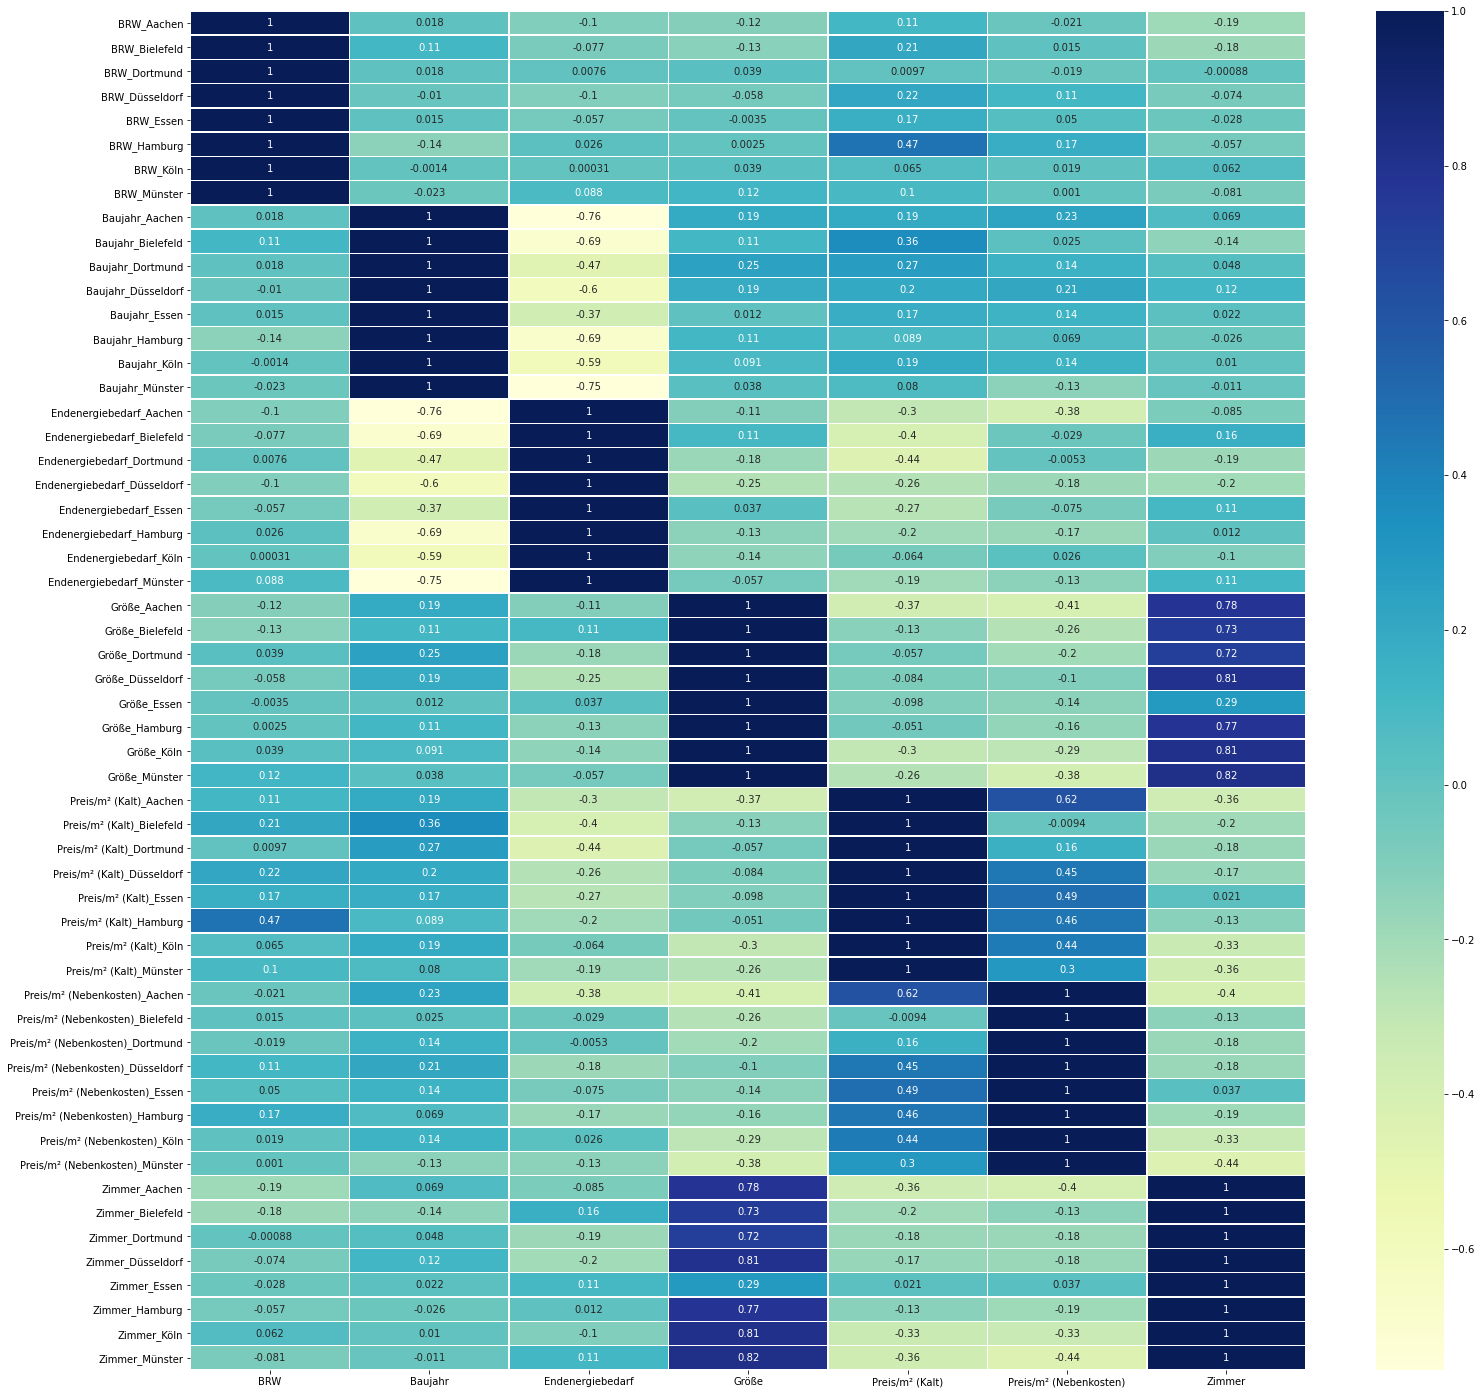

In [52]:
#Teil 2: Visuelle Darstellung der Korrelationstabelle mithilfe von Seaborn

sns.color_palette("crest", as_cmap=True)

fig, ax = plt.subplots(figsize=(25,25))

sns.heatmap(fulldf.reindex(sorted(fulldf.columns),axis=1), cmap="YlGnBu",
        xticklabels=sorted(fulldf.columns), annot=True, linecolor="white", linewidths=0.5,
        yticklabels=sorted(fulldf.index),ax=ax)

Text(0.5, 0, 'Bodenrichtwert')

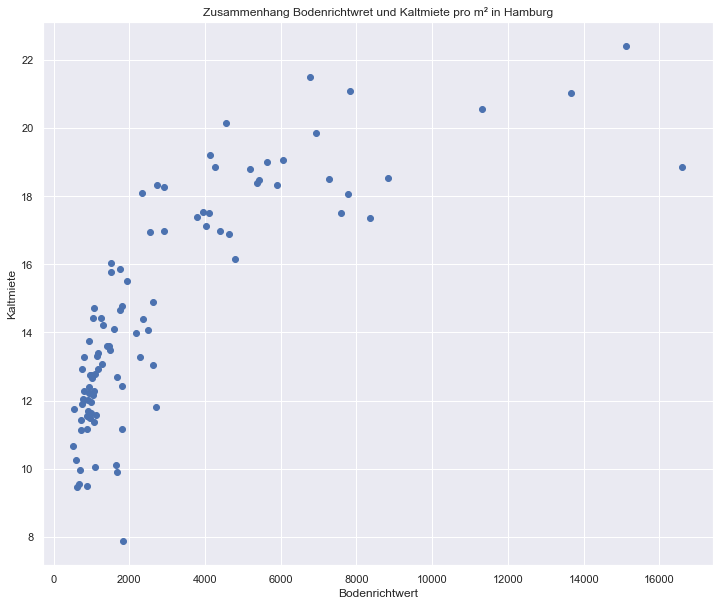

In [88]:
#Punkt-Diagramm zur Darstellung des Zusammenhangs zwischen a) Bodenrichtwwert und b) Kaltmiete pro m² in Hamburg

a = pd.pivot_table(data=df,index=["Stadt","PLZ"],values=["Preis/m² (Kalt)","BRW-Anteil","BRW"],aggfunc={"BRW-Anteil":[np.mean,"count"],"Preis/m² (Kalt)":[np.mean,"count"],"BRW":np.mean})

plt.scatter(x = a.loc["Hamburg",("BRW","mean")], y= a.loc["Hamburg",("Preis/m² (Kalt)","mean")])
plt.title("Zusammenhang Bodenrichtwret und Kaltmiete pro m² in Hamburg")
plt.ylabel("Kaltmiete")
plt.xlabel("Bodenrichtwert")


# 3.1 Map-Visualisierung

In [79]:
#Nachfolgend: Visualisierung der durchschnittlichen Kaltmiete pro m² auf Basis aller vorhandenen Datenpunke in Hamburg (prinzipiell für ganz Deutschland möglich, allerdings rechenintensiv) 

In [83]:
#Visualisierung auf Basis von PLZ-Bereichen
Buli = pd.read_excel("PLZ-Deutschland.xlsx",usecols=["PLZ","Bundesland"])

#FOLIUM Datenbasis: Choropleth
fname = 'plz-gebiete.shp'
nil = gpd.read_file(fname)
nil=nil[['plz','geometry']]
nil["plz"] = nil["plz"].astype("int64")

#NUR NRW
nil = nil.loc[nil["plz"].isin(Buli.loc[Buli["Bundesland"]=="Hamburg","PLZ"].values)]
nil.head()

nilpop=nil.merge(round(df.groupby(["PLZ"]).agg(Preis=("Preis/m² (Kalt)", "mean"),Count=("PLZ","count")).reset_index(),2),left_on="plz", right_on="PLZ")

nilpop.dropna(inplace=True, how="any", subset=["geometry"])

In [91]:
mymap = folium.Map(location=[53.55444278481244, 10.011624523814872], tiles="OpenStreetMap", zoom_start=10)
nilpop=nilpop.loc[:]

choropleth = folium.Choropleth(
     geo_data=nilpop,
     name='Choropleth',
     data=nilpop,
     columns=['PLZ',"Preis"],
     key_on="feature.properties.PLZ",
     bins=6,
     fill_color='YlGnBu',
     fill_opacity=0.6,
     line_opacity=0.6,
     legend_name="Kaltmiete in EUR pro m²",
     smooth_factor=0
).add_to(mymap)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['PLZ',"Preis", "Count"])
)


mymap



C:\Users\morit\anaconda3\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
